## Introduction

This tutorial will introduce you to some basic methods for processing geospatial data, particularly focusing on Geographic Information Systems (GIS) data.  Geospatial data forms a key aspect of data science. In many settings we want to visualize or analyze data with a spatial component: where (geographically) are certain features located, how do certain properties correlate with location, and can we identify spatial patterns in data?  Sometimes this also involves substantial analysis or machine learning, but sometimes just visuallizing data spatially tells us a great deal about some question we are interested in.

A classical example is the following map, created by John Snow in 1854:
[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/Snow-cholera-map-1.jpg/515px-Snow-cholera-map-1.jpg">](https://upload.wikimedia.org/wikipedia/commons/2/27/Snow-cholera-map-1.jpg)
(click for full-size version).  This is map of London in the 19th century, as it was experiencing a Cholera outbreak. John Snow took a map of the streets of London, and plotted the number of Cholera death spatially.  What emerged is that the deaths were clearly centered around a pump on Broad Street.  This visual evidence was enough to persuade the government council to remove the handle to the pump, and provided substantial evidence that Cholera was being spread by contaminated water (the well was later found to have been contaminated by sewage).

### Tutorial content

In this tutorial, we will show how to do some basic spatial analysis in Python, specifically using [GeoPandas](http://geopandas.org/), [Shapeley](http://toblerity.org/shapely/), and [GeoPy](https://geopy.readthedocs.io).

We'll be using data collected from the Pittsburgh GIS data repository from the Pittsburgh city planning department: http://pittsburghpa.gov/dcp/gis/gis-data-new.  While there aren't always public repositories for GIS data, a surprisingly large number of cities or counties maintain an up-to-date set of GIS data available on their web pages, and the analysis we do here could be repeated for many other cities as well.

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Loading data and plotting](#Loading-data-and-plotting)
- [Geometric operations](#Geometric-operations)
- [Spatial joins](#Spatial-joins)
- [Coordinate reference systems](#Coordinate-reference-systems)
- [Example application: adddress2neighborhood](#Example-application:-address2neighborhood)
- [Example applicaiton: Yelp by neighborhood](#Example-application:-Yelp-by-neighborhood)

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use.  You can install GeoPandas, Shapely (automatically installed as a dependency of GeoPandas), and GeoPy using `pip`:

    $ pip install --upgrade geopandas geopy
    
On my machine, GeoPandas throws an exception in its spatial join command unless the [Rtree](http://toblerity.org/rtree/) library is also installed.  There are instructions for installing Rtree on the web page above, but I was able to use the following command, which installed the relevant libraries:

    $ conda install -c ioos rtree
    
Note that this installs the rtree module from a private repository (called `ioos`), not an official conda package, so there is a chance it won't work for you, and you'll need to consult the documentation.  After you run all the installs, make sure the following commands work for you:

In [1]:
import geopandas as gpd
import shapely
from geopy.geocoders import GoogleV3
import rtree
import numpy as np

## Loading data and plotting

Now that we've installed and loaded the libraries, let's load our first geographic data.  We're going to load data provided in the "shapefile" format, which stores vector data that is geographically tagged (i.e., the points are expressed in terms of longitude/latitude or some other geographic coordinate system).

Download the `Census_Data.zip` file from the Pittsburgh city planning website: http://apps.pittsburghpa.gov/dcp/Census_Data.zip.  Then unzip the `Neighborhood.zip` file to create a `Neighborhood` folder with a number of files inside, including a `Neighborhood.shp` file.  This is the Shapefile we want, but in an odd quirk of the Shapefile format, you actually need all the files in this directory in order to properly load the file (GIS systems were developed before people knew how to properly create database files, apparently).  So you'll want to copy the entire `Neighborhood` directory into the same folder as this notebook, and you can then load the data using the following command.

In [2]:
df_neigh = gpd.read_file("Neighborhood/Neighborhood.shp");
df_neigh.head()

,ACRES,ALAND10,AREA,AWATER10,BLKGRPCE10,COUNTYFP10,DPWDIV,FID_BlockG,FID_Neighb,FUNCSTAT10,...,SQMILES,STATEFP10,Shape_Ar_1,Shape_Area,Shape_Le_1,Shape_Le_2,Shape_Leng,TRACTCE10,UNIQUE_ID,geometry
0,180.883,268195.0,7843108.0,0.0,1,003,3,0,62,S,...,0.281,42,7.843108e+06,7.842997e+06,11526.863222,11525.904546,7988.379391,040500,113,"POLYGON ((1355377.123158768 411531.0846695155,..."
1,320.679,75472.0,13904629.0,0.0,1,003,3,1,40,S,...,0.499,42,1.390463e+07,1.390469e+07,20941.386025,20945.562570,3813.620989,040400,25,"POLYGON ((1355110.970147774 417655.421174109, ..."
2,138.372,282679.0,5999801.5,0.0,2,003,3,2,61,S,...,0.215,42,5.999801e+06,5.998649e+06,18271.426385,18280.484515,8260.915502,040200,21,"POLYGON ((1352807.998047695 411926.938864693, ..."
3,166.101,284548.0,7202139.0,0.0,2,003,3,3,56,S,...,0.258,42,7.202139e+06,7.203631e+06,15696.759230,15694.771443,8670.428122,030500,19,"POLYGON ((1347150.050702184 413333.3376266807,..."
4,390.864,1593129.0,16947852.0,329216.0,1,003,1,5,27,S,...,0.608,42,1.694785e+07,1.694875e+07,23903.077852,24019.532672,24019.532865,020300,23,"POLYGON ((1349414.006476104 416876.8987810165,..."


The `df_neigh` object is of type `GeoDataFrame`, a subclass of a Pandas DataFrame, so you can use all the same calls you would use with a Pandas DataFrame.  If you select a column from the object (other than the special "geometry" data type referenced below), it will simply be a normal Pandas Series.  For example, if we wanted to get the total square miles over all neighborhoods, we could do so with the command:

In [3]:
df_neigh.loc[:,"SQMILES"].sum()

53.126000000000005

The one special element of a GeoDataFrame is that it has one additional column with the name "geometry".  This one column is a `GeoSeries` type, and contains a series of Shapely geometry objects.  We won't worry about using Shapely itself too much except to generate basic geometry types, for the case of the `df_neigh` object, each entroy of "geometry" contains a Shapely `Polygon` type, which describes the geometry of the neighborhood as a list of points.

In [4]:
g = df_neigh.loc[0,"geometry"]
print(str(g)[:100] + "...")

POLYGON ((1355377.123158768 411531.0846695155, 1355382.612321019 411522.5715631843, 1355390.25764694...


These points describe the outline of this speicfic neighborhood in Pittsburgh (the name is in the "HOOD" column), and this geometric information lets us plot the DataFrame visually.  Specifically, we can use the `.plot()` command to visualize the geometry of the entire DataFrame.  In this case, we can plot the data to view the neighborhoods of Pittsburgh visually:

In [3]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")
%matplotlib inline

/Users/zkolter/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


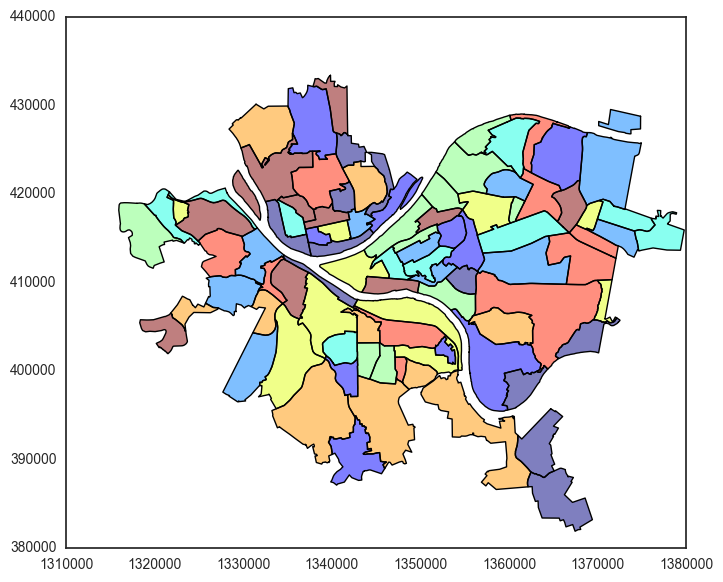

In [4]:
df_neigh.plot(figsize=(8,8), cmap="jet");

## Geometric operations

While the ability to simply plot the data is nice, is nice, one of the powerful aspects of these geometric tools is the ability to perform spatial operations on the data. For example, lets consider an alternative breakdown of the Pittsburgh area by _census block groups_.  These breakdowns are contained in `Block_Group_2010.zip` file folder as above.  Let's load the shapefile as before, and then plot it to visualize these breakdowns.

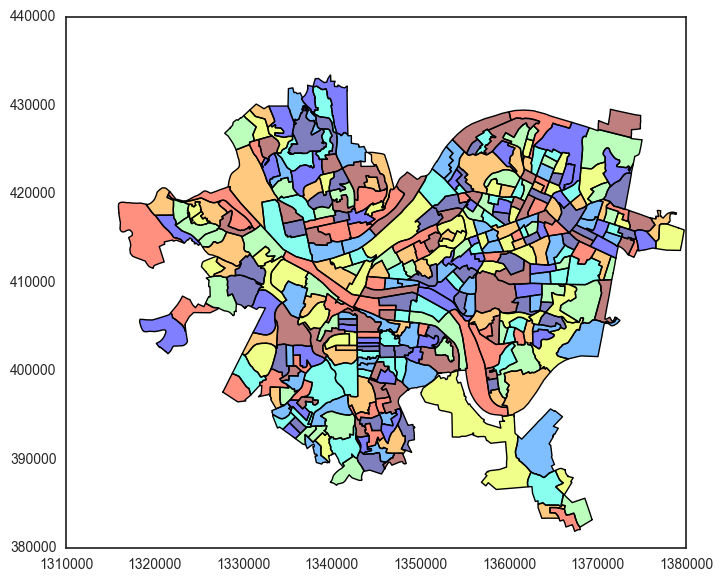

In [9]:
df_block_group = gpd.read_file("Block_Group_2010/Block_Group_2010.shp");
df_block_group.plot(figsize=(8,8), cmap="jet");

This looks ok, but unlike the neighborhood shapes, these block groups cover the river areas in Pittsburgh, so they don't look quite as nice as what we had previously.  To address this, we're going to compute the _intersection_ between each polygon in the `df_block_group` data frame and the union of all the neighborhoods (a an object we can get using the `.unary_union` property of a GeoDataFrame).  We can do this using the `.intersection()` command:

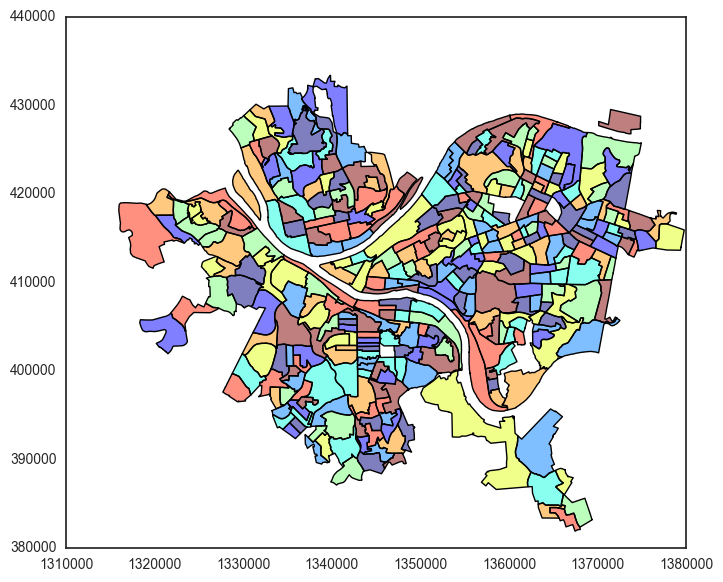

In [10]:
df_block_group["geometry"] = df_block_group.intersection(df_neigh.unary_union)
df_block_group.plot(figsize=(8,8), cmap="jet");

This looks good, but as a minor point, it looks like there are a few holes in this map.  What's happening here is that some of the intersections are resulting in `GeometryCollection` types instead of `Polygon` or `MultiPolygon` types (you can check this by looking at the type of each geometry).  This is likely a minor bug in the intersection code, and you can fix it by simply only keeping the polygons from the intersections, as follows.

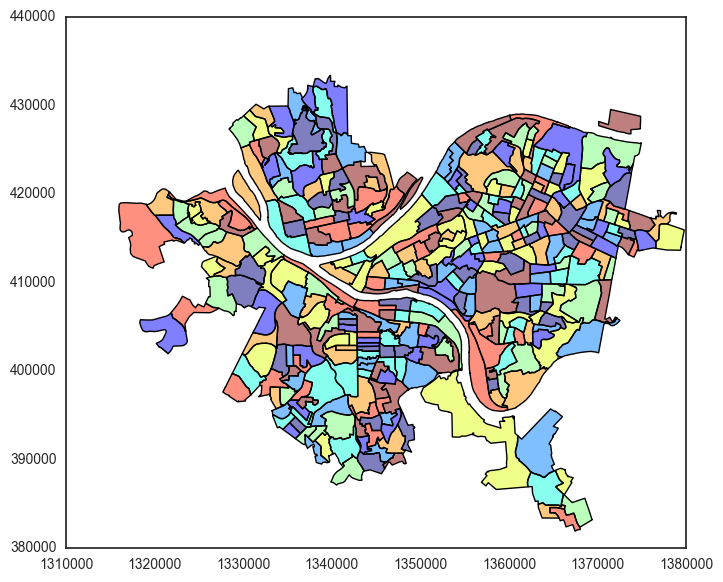

In [11]:
is_collection = lambda x : isinstance(x, shapely.geometry.collection.GeometryCollection)
to_multipolygon = lambda x : shapely.geometry.MultiPolygon([p for p in x if isinstance(p, shapely.geometry.Polygon)])

idx = df_block_group["geometry"].apply(is_collection)
df_block_group.loc[idx,"geometry"] = df_block_group.loc[idx,"geometry"].apply(to_multipolygon)
df_block_group.plot(figsize=(8,8), cmap="jet");

Much nicer.  The `.intersection()` is just one possible geometric operation.  We can also create unions between separate geometries (we already effectively did this with the `.unary_union` property), differences, symmetric differences, etc.

## Spatial joins

Similar to geometric operations, but also integrating the more relational components of GIS data is the notation of a "spatial join".  Just like traditional join operators merge tables based upon the value of certain columns in these two tables, a spatial join merges together two geospatial tables based upon properties of their geometry entries.  In a spatial join we merge together two rows that satisfy some geometric property between the rows.  The most obvious case is that we can, for instance, merge together rows where one geometry intersects with the other, or where one geometry is contained within the other.

This idea is best demonstrated through an example.  Let's suppose that we would like to build a map of the fair market value of residential homes within Pittsburgh, organized by census block group.  To get housing data, we'll download the `Land_Management.zip` file (http://apps.pittsburghpa.gov/dcp/Land_Management.zip) from the Pittsburgh GIS data, and specifically look at the `Parcels` shapefiles.

In [12]:
# Load the Parecels shapefile (note: this is a big file, and takes about a minute)
df_parcels = gpd.read_file("Parcels/Parcels.shp")

Now let's perform a spatial join between the parcels shapefile and our (modified) census block groups, to assign each parcel to one of the census block groups.

In [13]:
# Spatial join of df_block_group features, appended to all parcels
# located within that block group (takes about 30 seconds)
df_parcels = gpd.sjoin(df_parcels, df_block_group, how="inner", op="within")

After a spatial join the `index_right` column in the new GeoDataFrame indicates the index of the right data frame in the join.  If we want to aggregate together the entires within the same census group, we can thus use the `.groupby()` function, as we would in a normal Pandas DataFrame.  The following code computes the average fair market value (according the city Parcels database) of each home within the different census block groups.

In [14]:
# The parcels database has multiple fair-market column, so we take the max of these as our market value
df_parcels.loc[:,"MarketValue"] = df_parcels.loc[:,["FairMark_1", "FairMark_2", "FairMarket"]].apply(max, axis=1)

# select just the residential homes
df_residential = df_parcels.loc[df_parcels.loc[:,"StateDesc"]=="Residential", :]

# group by census block group index, and take the mean market value
df_block_group_values = df_residential.loc[:,["index_right", "MarketValue"]].groupby("index_right").mean()
df_block_group.loc[df_block_group_values.index,"MarketValue"] = df_block_group_values.loc[:,"MarketValue"]

Finally, we can plot the census block groups by their `MarketValue` column, by just passing this column to `.plot()`.

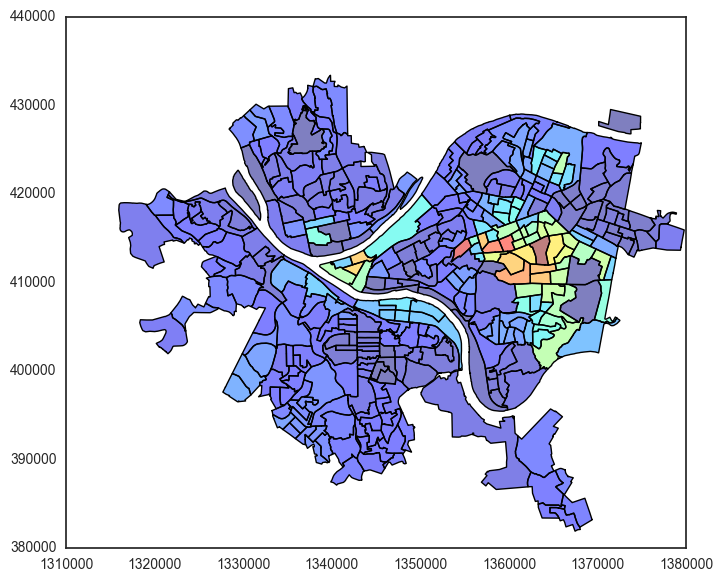

In [15]:
df_block_group.plot(column="MarketValue", figsize=(8,8), cmap="jet")

## Coordinate reference systems

One thing we haven't mentioned so far, which you've probably noticed when you look at the plots we've created an the geometry objects, is that the coordinates for points and polygons appear to be arbitrary numbers (eg. 1310000,380000), instead of a more familiar coordinate system like longitude/latitude.  The reason for this is simple: although lon/lat coordinates are useful for specifying a global position on a sphere, they aren't particularly good for drawing shapes geometrically: by their nature, for instance, one degree of longitude at Pittsburgh represents a very different distance than one degree of latitude.

In GIS files, this information is stored within what is called a "coordinate reference system", (CRS) which specifies the coordinate frame in which the distances are beinge expressed.  For example, this is the CRS for the Pittsburgh data.

In [16]:
df_neigh.crs

{u'datum': u'NAD83',
 u'lat_0': 39.33333333333334,
 u'lat_1': 39.93333333333333,
 u'lat_2': 40.96666666666667,
 u'lon_0': -77.75,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 600000,
 u'y_0': 0}

The precise quantities here are not very important (for a reference, see, e.g. http://proj4.org/) but this information can be used to convert to and from other coordinates like lon/lat.  The GeoPandas `.to_crs()` function accomplishes this.  The string "+proj=latlon" represents the coordinate system that uses typical lon/lat quantities, and we can convert to this system in the following way (plus plotting it, to both show the new coordinate system and to show how the figure gets distorted if we plot in raw lat/lon):

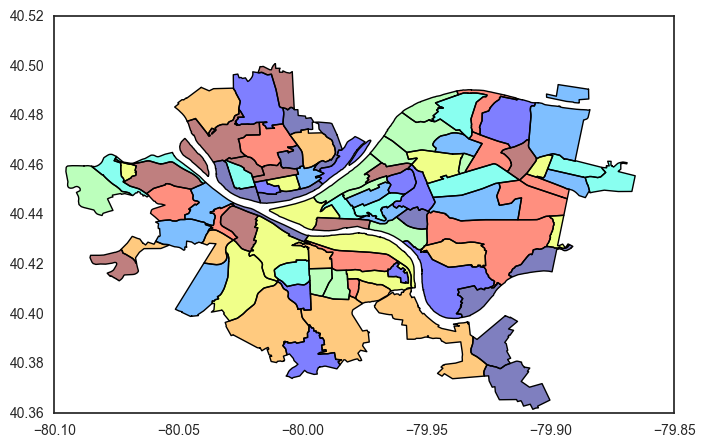

In [17]:
df_neigh.to_crs("+proj=latlon").plot(figsize=(8,8), cmap="jet");

## Example application: address2neighborhood

Let's put a few of these elements together to create an application you may find (marginally) useful as a CMU student.  Do you ever find yourself wanting to know which neighborhood in Pittsburgh contained a certain address?  We're going to build a function that will tell you, for a given address, what Pittsburgh neighborhood its in.

Of course, addresses themselves aren't coordinates we can immediately transform with GIS tools, so we need one additional ingredient: geocoding.  Geocoding refers to the job of converting traditional addresses (e.g., 5000 Forbes Ave), to lon/lat coordinates.  Doing so naturally requires that we have a large database of address locations, plus the ability to handle several potential formats for addresses, but the good news is that several online map providers provide APIs for geocoding.  The `geopy` is a library that provides easy access to many of these APIs.  Although most require you get authorization credentials, the GoogleV3 geocoder allows for a small number of anonymous queries.  Let's first see how to use this library to convert from address to lat/lon.

In [18]:
from geopy import GoogleV3
geocoder = GoogleV3()
geocoder.geocode("5000 Forbes Ave., Pittsburgh, PA")

Location((40.4434658, -79.9434567, 0.0))

Let's put this together with spatial queries to write our function that maps between addresses and neighborhoods.  The entirely of the process will involve:
1. Geocode the address to lon/lat coordinates
2. Convert these coordinates to the reference system of the Neighborhood shape file
3. Find and return the neighborhood that contains the addresses


In [19]:
def address2neighborhood(address, df_neigh, geocoder):
    loc = geocoder.geocode(address)
    s = gpd.GeoSeries(shapely.geometry.Point(loc.longitude, loc.latitude), crs="+proj=latlon").to_crs(df_neigh.crs)
    return df_neigh.loc[df_neigh.contains(s[0]),"HOOD"].iloc[0]

print(address2neighborhood("5000 Forbes Ave, Pittsburgh, PA", df_neigh, geocoder))
print(address2neighborhood("4000 Forbes Ave, Pittsburgh, PA", df_neigh, geocoder))

Squirrel Hill North
North Oakland


## Example application: Yelp by neighborhood

As a final, and slightly more involved example, let's consider how we can build a map of the restaurants in Pittsburgh (both the quantity and their quality), using a combination of the Yelp API, geocoding, and spatial joins.  In the meantime we also create our own shapefile for the Restaurants, so that we won't need to download repeatedly in the future.  [**NOTE:** this notebook actually uses an older version of the Yelp API that has been deprecated.  We will try to update to the newer Yelp API within the next week or two].  In the end, we create two maps, one of the quantity of restaurants in Pittsburgh (which shows that the downtown area is still the leader here), and the quality of restaurants (for neighborhoods with at least 10 restaurants), which shows that Lawrenceville is the current leader (with Brookline a close second?!).

In [ ]:
### load yelp API
import json
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator

with open("config_secret.json", "rt") as f:
    creds = json.load(f)
auth = Oauth1Authenticator(**creds)
client = Client(auth)

In [ ]:
# this function is helfup for displaying progress without printing too much output
from IPython.display import clear_output
import time

In [ ]:
# query all restaurants within city bounding box 
# (because this is more than the 1000 allowed by Yelp, need to divide it up)
T = 3
min_lon, min_lat, max_lon, max_lat = df_neigh.to_crs("+proj=latlon").unary_union.bounds
lats = np.linspace(min_lat, max_lat, T)
lons = np.linspace(min_lon, max_lon, T)

businesses = []
for i in range(T-1):
    for j in range(T-1):
        offset = 0
        res = client.search_by_bounding_box(lats[i+1], lons[j], lats[i], lons[j+1],
                                            category_filter="restaurants", offset=offset, limit=20)
        while len(res.businesses) > 0:
            clear_output(wait=True)
            print("{}/{}, {}/{}, {}/{}".format(i+1,T-1,j+1,T-1,offset,res.total))
            businesses += res.businesses
            offset += len(res.businesses)
            res = client.search_by_bounding_box(lats[i+1], lons[j], lats[i], lons[j+1],
                                            category_filter="restaurants", offset=offset, limit=20)


In [ ]:
# Use geocoder to find lat/lon for each business
locs = {}
for i,b in enumerate(businesses):
    clear_output(wait=True)
    print("{}/{}".format(i,len(businesses)))
    if len(b.location.address) > 0 and b.location.address[0] not in locs:
        locs[b.location.address[0]] = geocoder.geocode(b.location.address[0] + ", Pittsburgh, PA")
        time.sleep(0.05)

In [ ]:
# Create a GeoDataFrame with restaurant info
df_rest = gpd.GeoDataFrame([[b.name, b.rating, tuple(b.location.address), [a.name for a in b.categories]] 
                            for b in businesses], 
                           columns = ["Name", "Rating", "Address", "Categories"], crs="+proj=latlon")
df_rest["geometry"] = df_rest["Address"].apply(lambda x : shapely.geometry.Point(locs[x[0]].longitude, 
                                                                                 locs[x[0]].latitude)
                                               if len(x) > 0 and locs[x[0]] is not None else None)
df_rest.drop_duplicates(subset=["Name", "Address"], inplace=True)
df_rest = df_rest[df_rest["geometry"].apply(lambda x : x is not None)]
df_rest = df_rest.to_crs(df_neigh.crs)
df_rest = df_rest[df_rest.within(df_neigh.unary_union)]

df_rest["Categories"] = df_rest["Categories"].apply(lambda x : ", ".join(x))
df_rest["Address"] = df_rest["Address"].apply(lambda x : ", ".join(x))

# save the collected data to a shape file for easier loading in the future
df_rest.to_file("Restaurants", encoding="utf-8")

In [20]:
# In subsequent runs, we can just load the shapefile we have created
df_rest = gpd.read_file("Restaurants/Restaurants.shp")

In [21]:
# use a spatial join assign neighborhood to restaurants
df_rest = gpd.sjoin(df_rest.to_crs(df_neigh.crs), df_neigh[["geometry"]], how="inner", op="within")

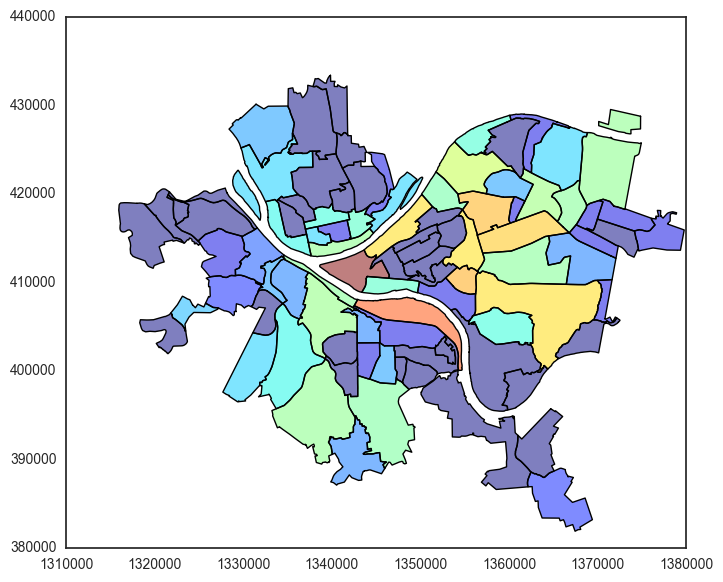

In [22]:
# create map of restaurant counts in neighborhoods
df_neigh["restaurant_count"] = df_rest.groupby("index_right").count().iloc[:,0]
df_neigh["restaurant_log_count"] = np.log(1+df_neigh["restaurant_count"])
df_neigh.plot(column='restaurant_log_count', cmap="jet", figsize=(8,8));

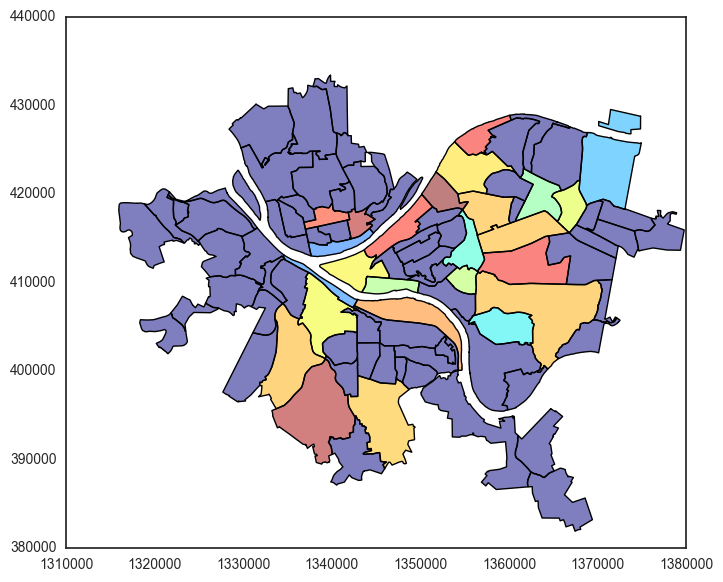

In [23]:
# create map of restaurant ratings (min 10 restaurants), by neighborhood
df_neigh["restaurant_rating"] = df_rest.groupby("index_right").mean()["Rating"]
df_neigh.loc[df_neigh["restaurant_count"] < 10, "restaurant_rating"] = np.float("nan")
df_neigh.plot(column='restaurant_rating', cmap="jet", figsize=(8,8));

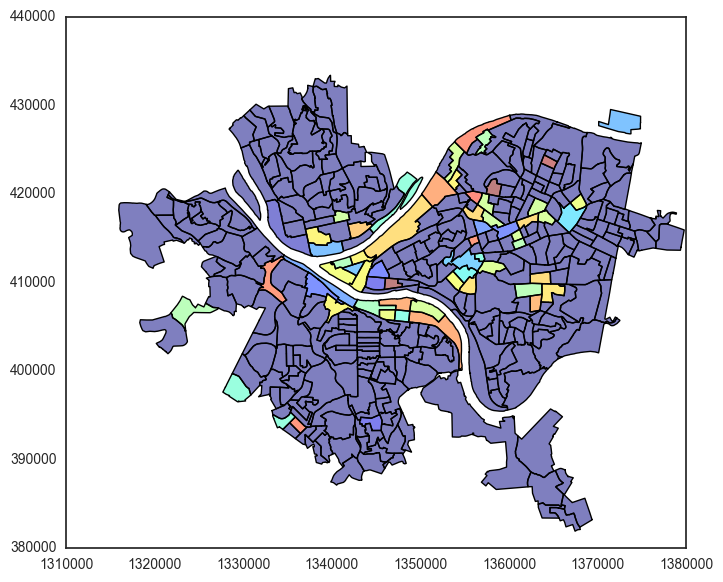

In [24]:
# do the same by block group, for illustration
df_rest = gpd.read_file("Restaurants/Restaurants.shp")
df_rest = gpd.sjoin(df_rest.to_crs(df_block_group.crs), df_block_group[["geometry"]], how="inner", op="within")
df_block_group["restaurant_count"] = df_rest.groupby("index_right").count().iloc[:,0]
df_block_group["restaurant_rating"] = df_rest.groupby("index_right").mean()["Rating"]
df_block_group.loc[df_block_group["restaurant_count"] < 5, "restaurant_rating"] = np.float("nan")
df_block_group.plot(column='restaurant_rating', cmap="jet", figsize=(8,8));

## Summary and references

This tutorial highlighted just a few elements of what is possible with data analyzed for geospatial data in Python.  Much more detail about the libraries and questions on GIS is general are available from the following links.

1. GeoPandas: http://geopandas.org
2. Shapeley: http://toblerity.org/shapely/
3. GeoPy: https://geopy.readthedocs.io
4. General GIS questions: http://gis.stackexchange.com/
5. Pitsburgh GIS data: http://pittsburghpa.gov/dcp/gis/gis-data-new
6. Cholera outbreak: https://www1.udel.edu/johnmack/frec682/cholera/